# Экзамен по ML

In [290]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from pandas_profiling import ProfileReport

import category_encoders
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn import svm
from sklearn.externals.joblib import parallel_backend

from xgboost import XGBClassifier
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
import keras.backend as K
from keras.layers import Conv2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.neural_network import MLPClassifier
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

In [291]:
def cm_matrix_plot(cm):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    classNames = ['1 class','2 class','3 class']
    plt.title('Confusion Matrix (normalized)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['T1','F2','F3'], ['F1', 'T2','F3'], ['F1', 'F2','T3']]
    for i in range(3):
        for j in range(3):
            plt.text(j,i, str(s[i][j])+" = "+str(round(cm[i][j],2)))
    plt.show()

In [292]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to sklearn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [293]:
df = pd.read_csv('dataset_57_hypothyroid.csv', sep=',')
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


## EDA

Для начала посмотрим информацию о данных и удалим пустые столбцы.

In [294]:
df = df.replace("?", np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
age                          3771 non-null object
sex                          3622 non-null object
on_thyroxine                 3772 non-null object
query_on_thyroxine           3772 non-null object
on_antithyroid_medication    3772 non-null object
sick                         3772 non-null object
pregnant                     3772 non-null object
thyroid_surgery              3772 non-null object
I131_treatment               3772 non-null object
query_hypothyroid            3772 non-null object
query_hyperthyroid           3772 non-null object
lithium                      3772 non-null object
goitre                       3772 non-null object
tumor                        3772 non-null object
hypopituitary                3772 non-null object
psych                        3772 non-null object
TSH_measured                 3772 non-null object
TSH                          3403 non-null 

In [295]:
df.drop('TBG', axis = 1, inplace=True)
df.drop_duplicates(inplace=True)

Проверим, есть ли пропущенные значения в target.

In [296]:
df.Class.isnull().sum()

0

Проверим соотношение классов, есть ли несбалансированность или нет.

In [297]:
df.Class.value_counts()

negative                   3420
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

In [298]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,3761,3762,3764,3765,3766,3767,3768,3769,3770,3771
age,41,23,46,70,70,18,59,80,66,68,...,38,61,54,73,19,30,68,74,72,64
sex,F,F,M,F,F,F,F,F,F,M,...,F,M,M,F,F,F,F,F,M,F
on_thyroxine,f,f,f,t,f,t,f,f,f,f,...,f,f,f,t,f,f,f,f,f,f
query_on_thyroxine,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
on_antithyroid_medication,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
sick,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
pregnant,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
thyroid_surgery,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
I131_treatment,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
query_hypothyroid,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f


В данных содержится всего 2 элемента класса secondary_hypothyroid. По-хорошему, мы бы хотели уметь отделять и этот класс, т.к. он соответствует людям с заболеванием, но из двух элементов хороший классификатор построить не получится, поэтому уберем этих двух человек из данных и будем строить классификатор для остальных трех классов.

In [299]:
df.drop(df[df['Class']=='secondary_hypothyroid'].index, axis = 0, inplace=True)

In [300]:
df['TSH']=pd.Series(df['TSH']).astype(float)
df['T3']=pd.Series(df['T3']).astype(float)
df['TT4']=pd.Series(df['TT4']).astype(float)
df['T4U']=pd.Series(df['T4U']).astype(float)
df['FTI']=pd.Series(df['FTI']).astype(float)
df['age']=pd.Series(df['age']).astype(float)

In [301]:
df.describe()

,age,TSH,T3,TT4,T4U,FTI
count,3708.000000,3400.000000,3000.000000,3538.000000,3383.000000,3385.000000
mean,51.864887,5.089456,2.013613,108.369927,0.995020,110.497400
std,20.127992,24.532057,0.827667,35.571119,0.195506,33.078955
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000


Видим, что максимальный возраст = 455, чего быть не может. Надо будет удалить эти выбросы.

In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3709 entries, 0 to 3771
Data columns (total 29 columns):
age                          3708 non-null float64
sex                          3560 non-null object
on_thyroxine                 3709 non-null object
query_on_thyroxine           3709 non-null object
on_antithyroid_medication    3709 non-null object
sick                         3709 non-null object
pregnant                     3709 non-null object
thyroid_surgery              3709 non-null object
I131_treatment               3709 non-null object
query_hypothyroid            3709 non-null object
query_hyperthyroid           3709 non-null object
lithium                      3709 non-null object
goitre                       3709 non-null object
tumor                        3709 non-null object
hypopituitary                3709 non-null object
psych                        3709 non-null object
TSH_measured                 3709 non-null object
TSH                          3400 non-null

In [303]:
df[df['pregnant']=='t']

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,Class
30,34.0,F,f,f,f,f,t,f,f,f,...,2.5,t,119.0,t,1.55,t,76.0,f,other,negative
126,30.0,F,f,f,f,f,t,f,f,f,...,NaN,t,125.0,t,1.43,t,87.0,f,STMW,negative
194,36.0,F,f,f,f,f,t,f,f,f,...,NaN,t,108.0,t,1.10,t,99.0,f,other,negative
199,32.0,F,t,f,f,f,t,f,f,f,...,3.7,t,139.0,t,1.34,t,104.0,f,other,negative
240,19.0,F,f,f,f,f,t,f,f,f,...,3.2,t,130.0,t,1.83,t,71.0,f,STMW,negative
364,25.0,F,f,f,f,f,t,f,f,f,...,2.2,t,113.0,t,1.08,t,105.0,f,STMW,negative
366,32.0,F,f,f,f,f,t,f,f,f,...,3.0,t,167.0,t,1.82,t,92.0,f,SVHC,negative
486,29.0,F,f,f,f,f,t,f,f,f,...,3.1,t,142.0,t,1.77,t,80.0,f,STMW,negative
530,26.0,F,f,f,f,f,t,f,f,f,...,NaN,t,151.0,t,1.97,t,76.0,f,other,negative
599,34.0,F,f,f,f,f,t,f,f,t,...,5.0,t,223.0,t,1.69,t,131.0,f,STMW,negative


Посмотрим на беременных индивидов, можем заполнить пропуски в графе "пол" на женский.

In [304]:
df[df['pregnant']=='t']

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,Class
30,34.0,F,f,f,f,f,t,f,f,f,...,2.5,t,119.0,t,1.55,t,76.0,f,other,negative
126,30.0,F,f,f,f,f,t,f,f,f,...,NaN,t,125.0,t,1.43,t,87.0,f,STMW,negative
194,36.0,F,f,f,f,f,t,f,f,f,...,NaN,t,108.0,t,1.10,t,99.0,f,other,negative
199,32.0,F,t,f,f,f,t,f,f,f,...,3.7,t,139.0,t,1.34,t,104.0,f,other,negative
240,19.0,F,f,f,f,f,t,f,f,f,...,3.2,t,130.0,t,1.83,t,71.0,f,STMW,negative
364,25.0,F,f,f,f,f,t,f,f,f,...,2.2,t,113.0,t,1.08,t,105.0,f,STMW,negative
366,32.0,F,f,f,f,f,t,f,f,f,...,3.0,t,167.0,t,1.82,t,92.0,f,SVHC,negative
486,29.0,F,f,f,f,f,t,f,f,f,...,3.1,t,142.0,t,1.77,t,80.0,f,STMW,negative
530,26.0,F,f,f,f,f,t,f,f,f,...,NaN,t,151.0,t,1.97,t,76.0,f,other,negative
599,34.0,F,f,f,f,f,t,f,f,t,...,5.0,t,223.0,t,1.69,t,131.0,f,STMW,negative


In [305]:
df.at[1609, 'sex'] = 'F'
df.at[3271, 'sex'] = 'F'

In [306]:
profile_report = ProfileReport(df)
profile_report

Number of variables,30
Number of observations,3709
Total Missing (%),1.8%
Total size in memory,869.4 KiB
Average record size in memory,240.0 B
Numeric,7
Categorical,22
Boolean,0
Date,0
Text (Unique),0
Rejected,1


Заметим, что признак TBG_measured константный, удалим его тоже.

Остальные признаки ..._measured говорят о том, проводилось ли измерение, они много информации в себе не несут (т.к. в случае false будет стоять просто пропуск в соответствующем столбце). 

In [307]:
df.drop('TBG_measured', axis = 1, inplace=True)

df.drop('FTI_measured', axis = 1, inplace=True)
df.drop('T3_measured', axis = 1, inplace=True)
df.drop('TSH_measured', axis = 1, inplace=True)
df.drop('TT4_measured', axis = 1, inplace=True)
df.drop('T4U_measured', axis = 1, inplace=True)

In [308]:
continuous_features = profile_report.get_description()['variables'][profile_report.get_description()['variables'].type == 
                                                                    'NUM'].index.values.tolist()
discrete_features = list(set(profile_report.get_description()['variables'][profile_report.get_description()['variables'].type == 
                                                                           'CAT'].index.values) - {'y'})

In [309]:
continuous_features.remove('index')
print(continuous_features)

['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age']


In [310]:
discrete_features.remove('Class')
discrete_features.remove('FTI_measured')
discrete_features.remove('T3_measured')
discrete_features.remove('TSH_measured')
discrete_features.remove('TT4_measured')
discrete_features.remove('T4U_measured')

In [311]:
print(discrete_features)

['goitre', 'I131_treatment', 'query_hyperthyroid', 'pregnant', 'hypopituitary', 'query_hypothyroid', 'thyroid_surgery', 'referral_source', 'lithium', 'on_antithyroid_medication', 'psych', 'on_thyroxine', 'tumor', 'sick', 'sex', 'query_on_thyroxine']


In [312]:
bool_features = ['query_hyperthyroid', 'thyroid_surgery', 'pregnant', 'on_thyroxine', 'query_hypothyroid', 'lithium', 'goitre', 'on_antithyroid_medication', 'hypopituitary', 'tumor', 'psych', 'query_on_thyroxine', 'I131_treatment', 'sick']

In [313]:
discrete_features = ['sex', 'referral_source']

In [314]:
print(continuous_features)

['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age']


Посмотрим на распределение непрерывных признаков.

C:\Users\123\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


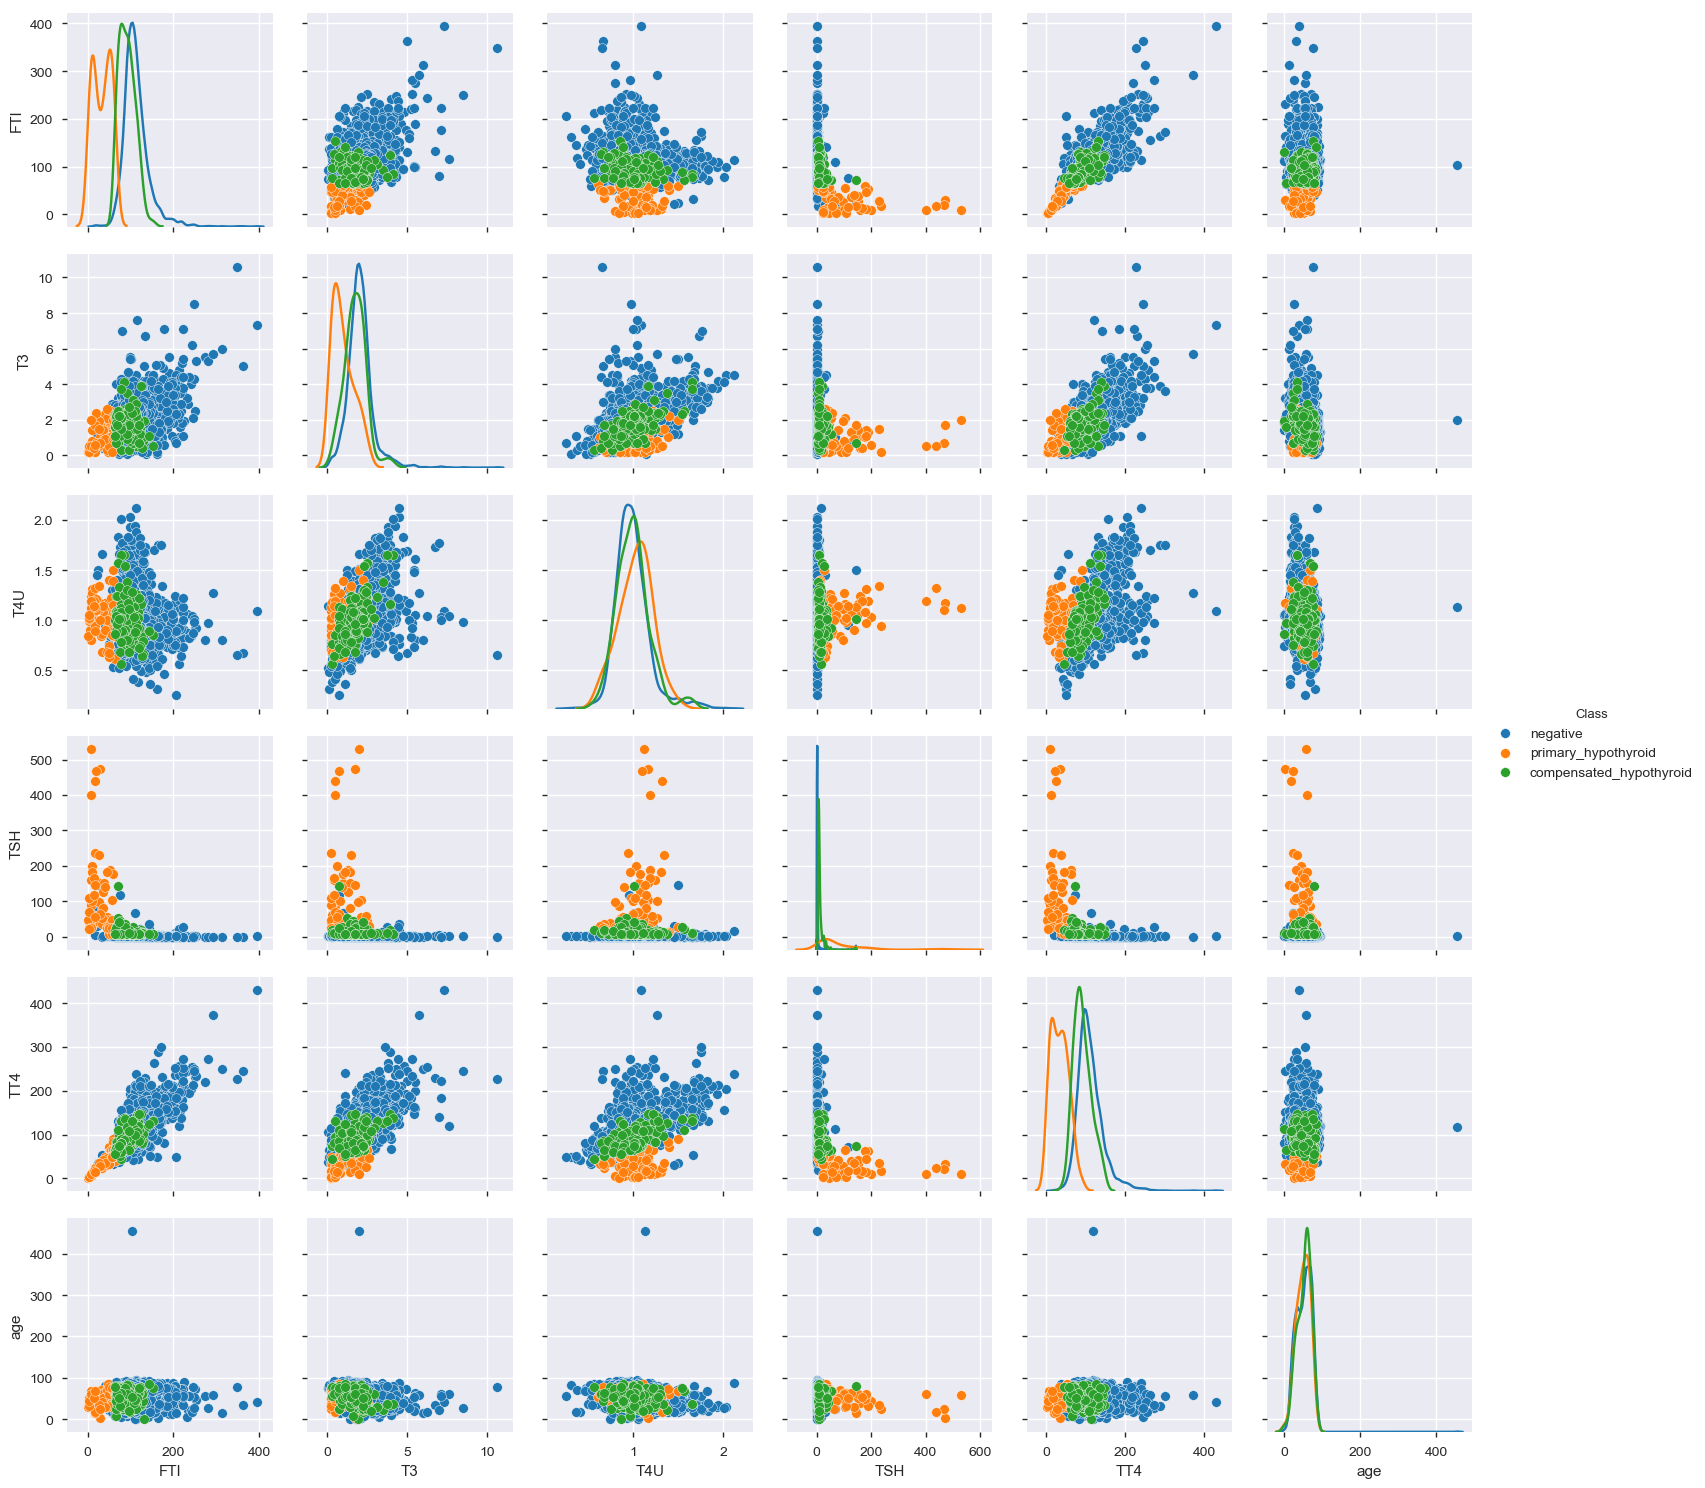

In [315]:
sns.pairplot(df[continuous_features+['Class']].dropna(), hue='Class', diag_kind = 'kde')

Из графика можно увидеть, что распределения некоторых признаков сильно несимметричные, надо бы их прологарифмировать, это мы сделаем позже.

In [316]:
df[df['age']>110]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
1364,455.0,F,f,f,f,f,f,f,f,f,...,f,f,f,1.1,2.0,118.0,1.13,104.0,SVI,negative


In [317]:
df.drop([1364], inplace=True)

Прологарифмируем несимметричные признаки.

In [318]:
df['FTI'] = np.log1p(df['FTI'])
df['T3'] = np.log1p(df['T3'])
df['TSH'] = np.log1p(df['TSH'])
df['TT4'] = np.log1p(df['TT4'])

C:\Users\123\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


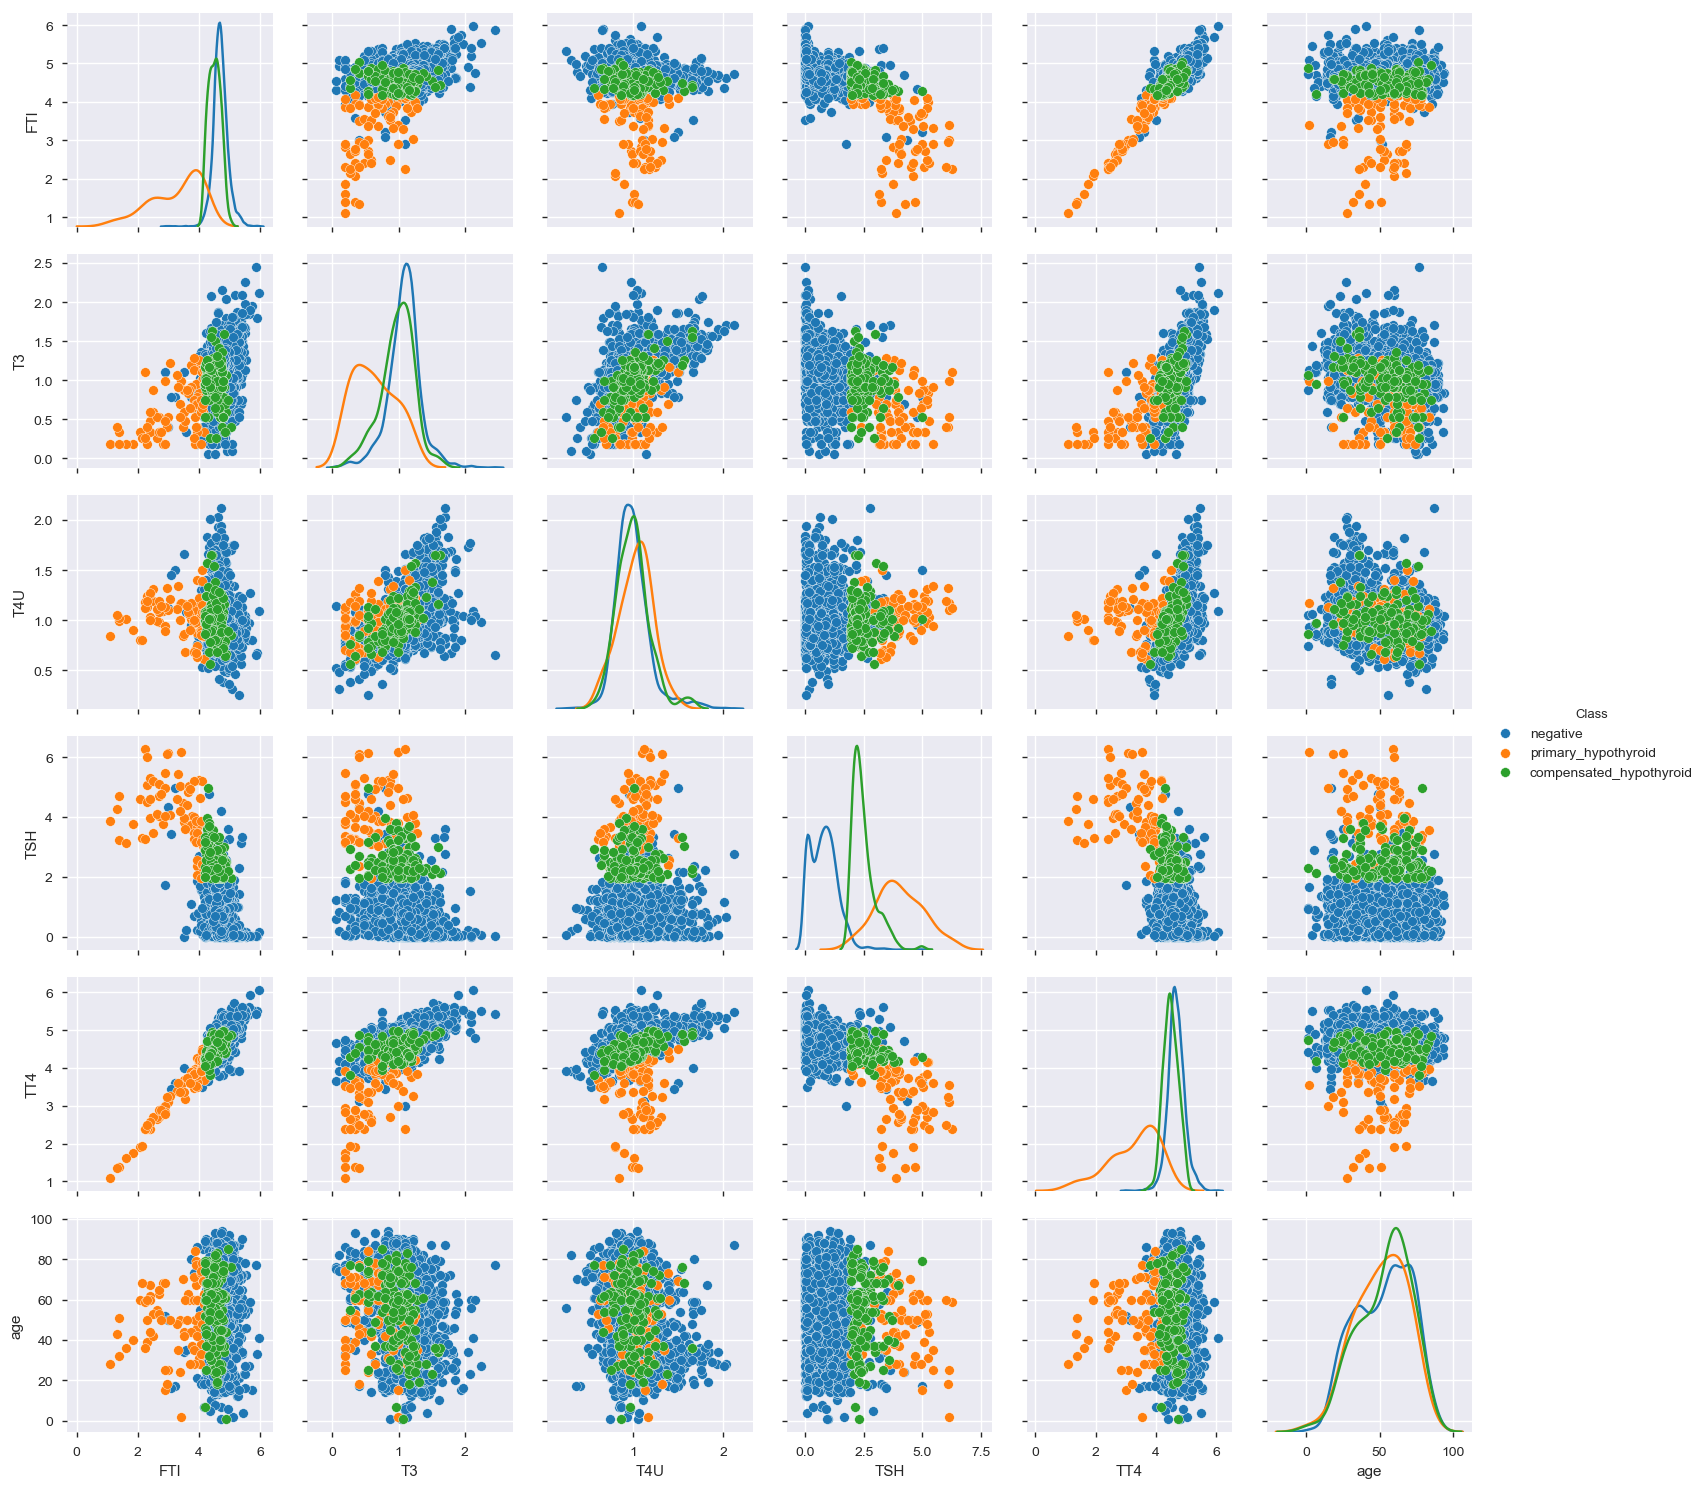

In [319]:
sns.pairplot(df[continuous_features+['Class']].dropna(), hue='Class', diag_kind ='kde')

In [320]:
df = df.replace("t", 1)
df = df.replace("f", 0)
df = df.replace("M", 1)
df = df.replace("F", 0)

Разделим данные на обучающую и тестовую части.

In [321]:
df.dropna(subset = ['sex'], inplace = True)

In [322]:
X, y = df.loc[:, df.columns != 'Class'], df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
train = pd.concat([X_train, y_train], axis=1, sort=False)
test = pd.concat([X_test, y_test], axis=1, sort=False)

In [323]:
X_train.shape

(2492, 22)

In [324]:
X_test.shape

(1069, 22)

Видим несбалансированность классов в тренировочной выборке, далее будем с этим бороться с помощью OverSampling и добавления весов классам.

## Metrics and cross-validation

Выберем метрику $F-score$ как нечто среднее между точностью и полнотой, но при оценке качества построенного классификатора будем также обращать внимание на precision и recall.

В данных нет признака, характеризующего время, поэтому можно не использовать TimeSeriesSplit. Также есть несбалансированность классов, будем использовать StratifiedKFold.

In [325]:
my_scorer = make_scorer(f1_score, average='macro')
skv = StratifiedKFold(5)

## Logistic regression

In [191]:
pipeline_LogRegr = Pipeline([
    ('feature union', FeatureUnion([
        ('discrete', Pipeline([
            ('select', ItemSelector(discrete_features)),
            ('encoder', category_encoders.OneHotEncoder(handle_unknown="ignore"))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features+ bool_features)),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('scale', RobustScaler()),
        ]))
    ])),
    ('balance', RandomOverSampler(random_state=15)),
    ('logisticregression', LogisticRegression(random_state=42, class_weight='balanced'))
])

Для того, чтобы избавиться от несбалансированности классов, будем использовать class_weight='balanced', который будет добавлять веса, пропорционально частоте класса, равные n_samples / (n_classes * np.bincount(y)).

In [192]:
params = dict(logisticregression__C = [0.001, 0.01, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0], 
              logisticregression__penalty = ['l1', 'l2'])

grid_clf = GridSearchCV(pipeline_LogRegr, params, cv=skv, scoring=my_scorer)

In [193]:
grid_clf.fit(X_train, y_train)

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class 

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('feature union', FeatureUnion(n_jobs=None,
       transformer_list=[('discrete', Pipeline(memory=None,
     steps=[('select', ItemSelector(key=['sex', 'referral_source'])), ('encoder', OneHotEncoder(cols=None, drop_invariant=False, handle_unknown='ignore',
       impute_missing=True, return_..., penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': [0.001, 0.01, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0], 'logisticregression__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=macro), verbose=0)

In [194]:
grid_clf.best_params_

{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1'}

In [195]:
grid_clf.best_score_

0.8631086433569886

In [196]:
y_pred = grid_clf.predict(X_test)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

compensated_hypothyroid       0.76      0.89      0.82        54
               negative       1.00      0.98      0.99       989
    primary_hypothyroid       0.72      0.88      0.79        26

              micro avg       0.98      0.98      0.98      1069
              macro avg       0.83      0.92      0.87      1069
           weighted avg       0.98      0.98      0.98      1069



In [197]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 48   0   6]
 [ 14 972   3]
 [  1   2  23]]


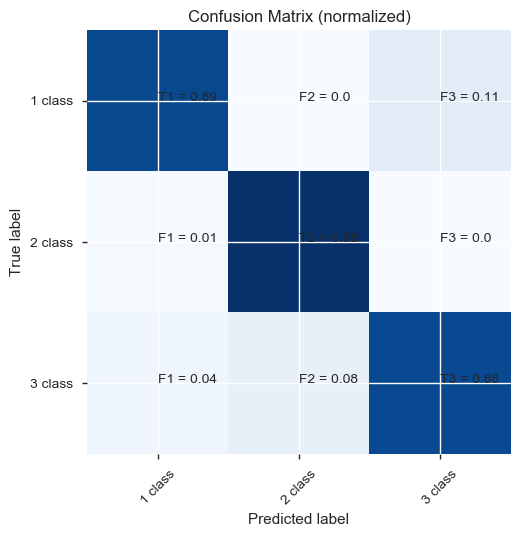

In [198]:
cm_matrix_plot(cm)

In [199]:
print("f1_score (test): ", f1_score(y_test, grid_clf.predict(X_test), average='macro'))

f1_score (test):  0.8679790687098291


In [200]:
# intialise data of lists. 
data = {'Name':['Logistic regression', 'Log regr with new features', 'Log regr + feature selection' , 'Decision tree' , 'Boosting', 'Neural Network (1 слой)'],
        'f1 score (train)':[0.0, 0, 0, 0, 0, 0], 'f1 score (test)':[0.0, 0, 0, 0, 0, 0]} 
df_results = pd.DataFrame(data) 

In [201]:
df_results.at[0,'f1 score (train)']=f1_score(y_train, grid_clf.predict(X_train), average='macro')
df_results.at[0,'f1 score (test)']=f1_score(y_test, grid_clf.predict(X_test), average='macro')

In [202]:
df_results

,Name,f1 score (train),f1 score (test)
0,Logistic regression,0.89684,0.867979
1,Log regr with new features,0.00000,0.000000
2,Log regr + feature selection,0.00000,0.000000
3,Decision tree,0.00000,0.000000
4,Boosting,0.00000,0.000000
5,Neural Network (1 слой),0.00000,0.000000


## Logistic regression with new features

Добавим квадраты и попарные произведения непрерывных признаков.

In [203]:
continuous_features=['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age']

In [204]:
continuous_features_old=['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age']

In [205]:
continuous_features_old=continuous_features
X_train0=X_train.copy()
X_test0=X_test.copy()

In [206]:
def add_features(df, num_col_names):
    for i in range(0,len(num_col_names)):
        for j in range(i, len(num_col_names)):
            df[num_col_names[i] + "_X_" + num_col_names[j] ] =  df[num_col_names[i]] * df[num_col_names[j]]
    print(df.shape)
    return df

In [207]:
X_train_2_fg = add_features(X_train0, continuous_features)
X_test_2_fg = add_features(X_test0, continuous_features)

(2492, 43)
(1069, 43)


In [208]:
X_train_2_fg.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T4U_X_T4U,T4U_X_TSH,T4U_X_TT4,T4U_X_age,TSH_X_TSH,TSH_X_TT4,TSH_X_age,TT4_X_TT4,TT4_X_age,age_X_age
2937,53.0,0.0,0,0,0,0,0,0,0,0,...,1.4161,6.083265,3.439542,63.07,26.132419,14.775545,270.935353,8.354249,153.189703,2809.0
782,50.0,0.0,0,0,0,0,0,0,0,1,...,1.1449,1.560718,5.009880,53.50,2.127558,6.829427,72.930751,21.922353,234.106561,2500.0
281,82.0,1.0,0,0,0,0,0,0,0,0,...,0.4624,0.747056,2.772725,55.76,1.206949,4.479633,90.086208,16.626312,334.358070,6724.0
2204,77.0,0.0,0,0,0,0,0,0,0,0,...,0.9216,1.146166,4.351296,73.92,1.425451,5.411572,91.932030,20.544458,349.010161,5929.0
1829,42.0,1.0,0,0,0,0,0,0,0,0,...,0.7569,1.787088,3.311796,36.54,4.219424,7.819356,86.273197,14.490679,159.879825,1764.0


In [209]:
list(X_train_2_fg.columns)

['age',
 'sex',
 'on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_medication',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'hypopituitary',
 'psych',
 'TSH',
 'T3',
 'TT4',
 'T4U',
 'FTI',
 'referral_source',
 'FTI_X_FTI',
 'FTI_X_T3',
 'FTI_X_T4U',
 'FTI_X_TSH',
 'FTI_X_TT4',
 'FTI_X_age',
 'T3_X_T3',
 'T3_X_T4U',
 'T3_X_TSH',
 'T3_X_TT4',
 'T3_X_age',
 'T4U_X_T4U',
 'T4U_X_TSH',
 'T4U_X_TT4',
 'T4U_X_age',
 'TSH_X_TSH',
 'TSH_X_TT4',
 'TSH_X_age',
 'TT4_X_TT4',
 'TT4_X_age',
 'age_X_age']

In [210]:
continuous_features = continuous_features + list(X_train_2_fg.columns)[-21:]

In [211]:
pipeline_LogRegr = Pipeline([
    ('feature union', FeatureUnion([
        ('discrete', Pipeline([
            ('select', ItemSelector(discrete_features)),
            ('encoder', category_encoders.OneHotEncoder(handle_unknown="ignore"))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features+bool_features)),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('scale', RobustScaler()),
        ]))
    ])),
    #('balance', RandomOverSampler(random_state=15)),
    ('logisticregression', LogisticRegression(random_state=42, class_weight='balanced'))
])

In [212]:
params = dict(logisticregression__C = [0.001, 1.0, 10.0, 25.0, 50.0, 100.0,  500.0],
             logisticregression__penalty = ['l1', 'l2'])

grid_clf = GridSearchCV(pipeline_LogRegr, params, cv=skv, scoring=my_scorer)

In [214]:
%%time

with parallel_backend('threading'):
    grid_clf.fit(X_train_2_fg, y_train)

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. 

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

C:\Users\123\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Sp

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Sp

Wall time: 2min 54s


C:\Users\123\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [215]:
grid_clf.best_params_

{'logisticregression__C': 10.0, 'logisticregression__penalty': 'l1'}

In [216]:
grid_clf.best_score_

0.9081714010560481

In [217]:
y_pred = grid_clf.predict(X_test_2_fg)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

compensated_hypothyroid       0.85      0.94      0.89        54
               negative       1.00      0.99      0.99       989
    primary_hypothyroid       0.88      0.85      0.86        26

              micro avg       0.99      0.99      0.99      1069
              macro avg       0.91      0.93      0.92      1069
           weighted avg       0.99      0.99      0.99      1069



In [218]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 51   1   2]
 [  7 981   1]
 [  2   2  22]]


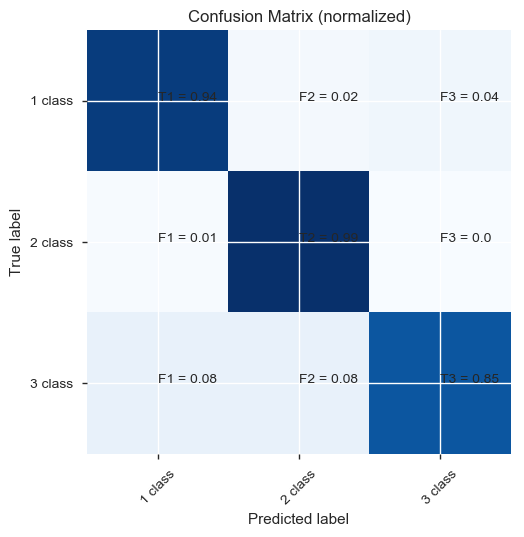

In [219]:
cm_matrix_plot(cm)

In [220]:
print(f1_score(y_train, grid_clf.predict(X_train_2_fg), average='macro'))
print(f1_score(y_test, grid_clf.predict(X_test_2_fg), average='macro'))

0.971029944803246
0.9173022246840778


In [221]:
df_results.at[1,'f1 score (train)']=f1_score(y_train, grid_clf.predict(X_train_2_fg), average='macro')
df_results.at[1,'f1 score (test)']=f1_score(y_test, grid_clf.predict(X_test_2_fg), average='macro')

In [222]:
df_results

,Name,f1 score (train),f1 score (test)
0,Logistic regression,0.89684,0.867979
1,Log regr with new features,0.97103,0.917302
2,Log regr + feature selection,0.00000,0.000000
3,Decision tree,0.00000,0.000000
4,Boosting,0.00000,0.000000
5,Neural Network (1 слой),0.00000,0.000000


### Log regression with feature selection

In [223]:
from sklearn.feature_selection import SelectFromModel

pipeline_LogRegr_sel = Pipeline([
    ('feature union', FeatureUnion([
        ('discrete', Pipeline([
            ('select', ItemSelector(discrete_features)),
            ('encoder', category_encoders.OneHotEncoder(handle_unknown="ignore"))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features+bool_features)),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('scale', RobustScaler()),
        ]))
    ])),
    #('balance', RandomOverSampler(random_state=15)),
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(class_weight='balanced'))),
    ('logisticregression', LogisticRegression(random_state=42, class_weight='balanced'))
])

In [224]:
params = dict(logisticregression__C = [0.001, 1.0, 10.0, 25.0, 50.0, 100.0, 500.0],
             logisticregression__penalty = ['l1', 'l2'])

grid_clf_sel = GridSearchCV(pipeline_LogRegr_sel, params, cv=skv, scoring=my_scorer)

In [225]:
%%time

with parallel_backend('threading'):
    grid_clf_sel.fit(X_train_2_fg, y_train)

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class 

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class 

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

Wall time: 27.3 s


C:\Users\123\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [226]:
grid_clf_sel.best_params_

{'logisticregression__C': 25.0, 'logisticregression__penalty': 'l1'}

In [227]:
grid_clf_sel.score(X_train_2_fg, y_train)

0.9363332077771206

In [228]:
grid_clf_sel.score(X_test_2_fg, y_test)

0.9132620815795853

In [229]:
y_pred = grid_clf_sel.predict(X_test_2_fg)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

compensated_hypothyroid       0.85      0.96      0.90        54
               negative       1.00      0.99      1.00       989
    primary_hypothyroid       0.88      0.81      0.84        26

              micro avg       0.99      0.99      0.99      1069
              macro avg       0.91      0.92      0.91      1069
           weighted avg       0.99      0.99      0.99      1069



In [230]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 52   0   2]
 [  6 982   1]
 [  3   2  21]]


In [231]:
print(f1_score(y_train, grid_clf_sel.predict(X_train_2_fg), average='macro'))
print(f1_score(y_test, grid_clf_sel.predict(X_test_2_fg), average='macro'))

0.9363332077771206
0.9132620815795853


In [232]:
df_results.at[2,'f1 score (train)']=f1_score(y_train, grid_clf_sel.predict(X_train_2_fg), average='macro')
df_results.at[2,'f1 score (test)']=f1_score(y_test, grid_clf_sel.predict(X_test_2_fg), average='macro')

In [233]:
df_results

,Name,f1 score (train),f1 score (test)
0,Logistic regression,0.896840,0.867979
1,Log regr with new features,0.971030,0.917302
2,Log regr + feature selection,0.936333,0.913262
3,Decision tree,0.000000,0.000000
4,Boosting,0.000000,0.000000
5,Neural Network (1 слой),0.000000,0.000000


### Decision tree

In [234]:
continuous_features = continuous_features_old
continuous_features

['FTI', 'T3', 'T4U', 'TSH', 'TT4', 'age']

In [258]:
from sklearn.tree import DecisionTreeClassifier
import random
random.seed(11)

pipeline_DT = Pipeline([
    ('feature union', FeatureUnion([
        ('discrete', Pipeline([
            ('select', ItemSelector(discrete_features)),
           # ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('encoder', category_encoders.OneHotEncoder(handle_unknown="ignore"))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features+bool_features)),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('scale', RobustScaler()),
        ]))
    ])),
    #('balance', RandomOverSampler(random_state=15)),
    #('pca', decomposition.PCA()),
    #('feature_selection', SelectFromModel(LinearSVC(penalty="l1",dual=False, max_iter=100000))),
    ('DTC', DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced"))
])

In [259]:
param_grid = {'DTC__max_depth':[3,5,10,15], 'DTC__criterion':['gini', 'entropy'],
             'DTC__min_samples_leaf': [2]}

grid_clf_DT = GridSearchCV(pipeline_DT, param_grid, cv=skv, scoring=my_scorer)

In [260]:
%%time

with parallel_backend('threading'):
    grid_clf_DT.fit(X_train, y_train)

Wall time: 4.85 s


In [261]:
grid_clf_DT.best_params_

{'DTC__criterion': 'gini', 'DTC__max_depth': 15, 'DTC__min_samples_leaf': 2}

In [262]:
y_pred = grid_clf_DT.predict(X_test)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

compensated_hypothyroid       0.71      0.76      0.73        54
               negative       0.99      0.98      0.98       989
    primary_hypothyroid       0.81      0.85      0.83        26

              micro avg       0.97      0.97      0.97      1069
              macro avg       0.84      0.86      0.85      1069
           weighted avg       0.97      0.97      0.97      1069



In [263]:
print(f1_score(y_train, grid_clf_DT.predict(X_train), average='macro'))
print(f1_score(y_test, grid_clf_DT.predict(X_test), average='macro'))

0.9293289592052968
0.8488731409518162


In [264]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 41  11   2]
 [ 15 971   3]
 [  2   2  22]]


In [265]:
df_results.at[3,'f1 score (train)']=f1_score(y_train, grid_clf_DT.predict(X_train), average='macro')
df_results.at[3,'f1 score (test)']=f1_score(y_test, grid_clf_DT.predict(X_test), average='macro')

In [266]:
df_results

,Name,f1 score (train),f1 score (test)
0,Logistic regression,0.896840,0.867979
1,Log regr with new features,0.971030,0.917302
2,Log regr + feature selection,0.936333,0.913262
3,Decision tree,0.929329,0.848873
4,Boosting,0.000000,0.000000
5,Neural Network (1 слой),0.000000,0.000000


In [243]:
err_train, err_test = [], []

min_depth = 1
max_depth = 50

import random
random.seed(17)

for i in range(min_depth, max_depth + 1):
    #clf = DecisionTreeClassifier(criterion='entropy',
     #                            max_depth=i)
    
    clf = Pipeline([
    ('feature union', FeatureUnion([
        ('discrete', Pipeline([
            ('select', ItemSelector(discrete_features)),
            ('encoder', category_encoders.OneHotEncoder(handle_unknown="ignore"))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features+bool_features)),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('scale', RobustScaler()),
        ]))
    ])),
    ('DTC', DecisionTreeClassifier(max_depth=i, max_features = "auto", class_weight = "balanced"))
])
    
        
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    f1_train = f1_score(y_train, y_pred_train, average = 'macro')
    f1_test = f1_score(y_test, y_pred_test, average = 'macro')

    #scores = cross_val_score(clf, cancer.data, cancer.target, cv = 5)
    #acc_test = scores.mean()
    
    err_train.append(f1_train)
    err_test.append(f1_test)

C:\Users\123\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


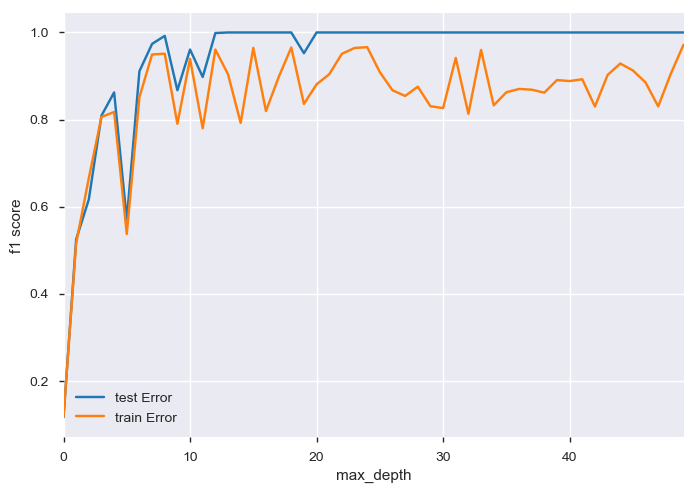

In [244]:
plt.plot(err_train, label = "test Error")
plt.plot(err_test, label = "train Error")

plt.xlim(min_depth - 1, max_depth - 1)
plt.xlabel("max_depth")
plt.ylabel("f1 score")
plt.legend()
plt.show()

## Boosting

### Adaboost

In [326]:
from sklearn.ensemble import AdaBoostClassifier

DTC = DecisionTreeClassifier(max_depth=3, random_state = 11, max_features = "auto", class_weight = "balanced")

pipeline_adaboost = Pipeline([
    ('feature union', FeatureUnion([
        ('discrete', Pipeline([
            ('select', ItemSelector(discrete_features)),
           # ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('encoder', category_encoders.OneHotEncoder(handle_unknown="ignore"))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features+bool_features)),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('scale', RobustScaler()),
        ]))
    ])),
    #('balance', RandomOverSampler(random_state=15)),
    #('pca', decomposition.PCA()),
    #('feature_selection', SelectFromModel(LinearSVC(penalty="l1",dual=False, max_iter=100000))),
    ('adaboost', AdaBoostClassifier(base_estimator = DTC))
])

In [246]:
param_grid = {'adaboost__n_estimators':[5,50,100,1000], 'adaboost__learning_rate':[0.0001,0.001,0.01,0.1]}

In [247]:
grid_clf_ada = GridSearchCV(pipeline_adaboost, param_grid, cv=skv, scoring=my_scorer)

In [248]:
%%time

with parallel_backend('threading'):
    grid_clf_ada.fit(X_train, y_train)

C:\Users\123\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 3min 14s


In [327]:
grid_clf_ada.best_params_

{'adaboost__learning_rate': 0.1, 'adaboost__n_estimators': 1000}

In [328]:
y_pred = grid_clf_ada.predict(X_test)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

compensated_hypothyroid       1.00      1.00      1.00        54
               negative       1.00      1.00      1.00       989
    primary_hypothyroid       1.00      0.88      0.94        26

              micro avg       1.00      1.00      1.00      1069
              macro avg       1.00      0.96      0.98      1069
           weighted avg       1.00      1.00      1.00      1069



In [329]:
print(f1_score(y_train, grid_clf_ada.predict(X_train), average='macro'))
print(f1_score(y_test, grid_clf_ada.predict(X_test), average='macro'))

0.9973828016004962
0.9790870411768947


In [330]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 54   0   0]
 [  0 989   0]
 [  0   3  23]]


In [331]:
df_results.at[4,'f1 score (train)']=f1_score(y_train, grid_clf_ada.predict(X_train), average='macro')
df_results.at[4,'f1 score (test)']=f1_score(y_test, grid_clf_ada.predict(X_test), average='macro')

In [332]:
df_results

,Name,f1 score (train),f1 score (test)
0,Logistic regression,0.896840,0.867979
1,Log regr with new features,0.971030,0.917302
2,Log regr + feature selection,0.936333,0.913262
3,Decision tree,0.929329,0.848873
4,Boosting,0.997383,0.979087
5,Neural Network (1 слой),0.000000,0.000000


### Gradient boosting

In [330]:
pipeline_xgboost = Pipeline([
    ('feature union', FeatureUnion([
        ('discrete', Pipeline([
            ('select', ItemSelector(discrete_features)),
           # ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('encoder', category_encoders.OneHotEncoder(handle_unknown="ignore"))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features+bool_features)),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('scale', RobustScaler()),
        ]))
    ])),
    ('balance', RandomOverSampler(random_state=15)),
    #('pca', decomposition.PCA()),
    #('feature_selection', SelectFromModel(LinearSVC(penalty="l1",dual=False, max_iter=100000))),
    ('xgb', XGBClassifier(seed=15))
])

In [331]:
params = dict(xgb__objective=['reg:logistic'],
              xgb__learning_rate= [0.1, 0.05], #so called `eta` value
              xgb__max_depth= [3,4,6],
              xgb__min_child_weight= [1,5,10],
              xgb__silent=[1],
              xgb__subsample= [0.6, 0.8],
              xgb__colsample_bytree= [0.7],
              xgb__n_estimators= [10, 50],
              xgb__gamma=[i/10.0 for i in range(0,5)])

grid_clf_xgb = GridSearchCV(pipeline_xgboost, params, cv=skv, scoring=my_scorer, verbose=10)

In [332]:
%%time

with parallel_backend('threading'):
    grid_clf_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 [CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 

[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9625852647446768, total=   2.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   2.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.3s


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9550842600022929, total=   2.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   2.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.2s


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9798798441935697, total=   4.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9457803992740472, total=   4.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weig

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.8s


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.961285493308783, total=   4.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9872900222626999, total=   5.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.1s


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   2.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9295530492898915, total=   2.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 [CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.7s


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   4.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   4.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weig

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9569592898910854, total=   2.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9699259286761839, total=   2.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 [CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weigh

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   49.4s


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9457803992740472, total=   4.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   4.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 [CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_w

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.0min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   2.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9798798441935697, total=   2.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.3min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806060606060606, total=   5.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   3.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.5min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9457803992740472, total=   5.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   5.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weig

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.8min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9699259286761839, total=   2.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9499116794068879, total=   2.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_wei

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9798798441935697, total=   3.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9683950049796981, total=   3.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.5min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9743984005816068, total=   5.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   3.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.8min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9295530492898915, total=   6.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   7.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weig

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3.2min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   5.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9742133517233919, total=   5.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   4.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9676672029418524, total=   4.3s[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9295530492898915, total=   4.3s

[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rat

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   4.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  3.8min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   4.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   4.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   4.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   5.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  4.2min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   5.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   5.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_c

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.961285493308783, total=   5.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   5.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  4.6min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9743984005816068, total=   5.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   2.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_we

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9499116794068879, total=   5.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9295530492898915, total=   5.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.1min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9550842600022929, total=   5.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   5.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9550842600022929, total=   5.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   5.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  5.5min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9863039535727239, total=   4.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9579978461137445, total=   3.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_we

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   3.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   3.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_wei

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  6.1min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   6.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9295530492898915, total=   6.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   3.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9591873459178348, total=   6.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_ch

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.8min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.0, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9499116794068879, total=   7.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9676672029418524, total=   2.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weigh

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   2.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9237545015117377, total=   2.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  7.2min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   2.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   2.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9742133517233919, total=   2.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9644736842105264, total=   2.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weig

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  7.7min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   5.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   5.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9743984005816068, total=   5.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.961285493308783, total=   5.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weigh

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.3min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   2.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   2.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9237545015117377, total=   3.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   2.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weig

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  8.8min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   5.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   4.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.961285493308783, total=   6.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.94175108733825, total=   6.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  9.4min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   3.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9295530492898915, total=   3.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   3.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9237545015117377, total=   3.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_wei

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 10.1min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9499116794068879, total=   6.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9699259286761839, total=   2.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_we

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9295530492898915, total=   4.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9625852647446768, total=   4.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_w

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed: 10.6min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   4.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9295530492898915, total=   4.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9540588443814251, total=   5.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   4.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_c

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 11.2min


[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9676672029418524, total=   3.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9625852647446768, total=   2.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weig

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   2.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   3.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_wei

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 11.9min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   5.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9074400391581007, total=   3.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9550842600022929, total=   4.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   5.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child

[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 12.7min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9863039535727239, total=   6.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   3.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_we

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9295530492898915, total=   5.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9499116794068879, total=   6.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child

[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed: 13.4min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   5.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   5.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.1, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_c

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.961285493308783, total=   4.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   4.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weigh

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   4.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 


[Parallel(n_jobs=-1)]: Done 753 tasks      | elapsed: 14.1min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   5.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   4.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weig

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   4.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   4.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.7min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9743984005816068, total=   5.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.961285493308783, total=   5.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weigh

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   5.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   4.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weig

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   5.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 


[Parallel(n_jobs=-1)]: Done 833 tasks      | elapsed: 15.4min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   4.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   4.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.961285493308783, total=   6.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9872900222626999, total=   5.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weigh

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   5.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   5.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 


[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 16.2min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   6.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   5.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weig

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   5.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9742133517233919, total=   5.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9625852647446768, total=   5.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   4.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child

[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed: 17.1min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9550842600022929, total=   4.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   2.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_we

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9219991333237036, total=   3.0s[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9499116794068879, total=   5.4s

[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9295530492898915, total=   4.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9499116794068879, total=   4.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child

[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed: 17.7min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   4.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9457803992740472, total=   2.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_w

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   2.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9457803992740472, total=   2.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_wei

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9550842600022929, total=   4.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   4.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 18.5min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   2.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9499116794068879, total=   2.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_chil

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9863039535727239, total=   3.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.951786995721354, total=   3.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_wei

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   3.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   3.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_wei

[Parallel(n_jobs=-1)]: Done 1050 tasks      | elapsed: 19.4min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9295530492898915, total=   6.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   6.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   3.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9237545015117377, total=   5.8s
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9591873459178348, total=   5.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.2, xgb__learning_

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   2.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9798798441935697, total=   4.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weigh

[Parallel(n_jobs=-1)]: Done 1097 tasks      | elapsed: 20.3min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9743984005816068, total=   4.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   2.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9457803992740472, total=   5.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9499116794068879, total=   4.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weig

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   4.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9457803992740472, total=   5.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_we

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 21.1min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9798798441935697, total=   2.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   2.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   2.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   2.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   2.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9742133517233919, total=   2.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weig

[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 21.9min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   4.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   4.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9743984005816068, total=   6.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.961285493308783, total=   6.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weigh

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9295530492898915, total=   5.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   6.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weig

[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 22.9min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   3.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   3.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weig

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9742133517233919, total=   5.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9625852647446768, total=   2.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_we

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   4.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9569592898910854, total=   2.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_we

[Parallel(n_jobs=-1)]: Done 1293 tasks      | elapsed: 23.8min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   5.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   4.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   4.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=   5.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_c

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9295530492898915, total=   5.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9683950049796981, total=   5.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child

[Parallel(n_jobs=-1)]: Done 1344 tasks      | elapsed: 24.7min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   2.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   2.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_wei

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9490906613444907, total=   3.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9451694408263759, total=   2.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9683950049796981, total=   3.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.961285493308783, total=   3.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weig

[Parallel(n_jobs=-1)]: Done 1397 tasks      | elapsed: 25.7min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9743984005816068, total=   6.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   3.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_we

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9295530492898915, total=   6.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9499116794068879, total=   6.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   5.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.3, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9237545015117377, total=   5.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 26.7min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9798798441935697, total=   4.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806060606060606, total=   4.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weig

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   2.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9457803992740472, total=   4.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weigh

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9550842600022929, total=   2.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   2.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_child_we

[Parallel(n_jobs=-1)]: Done 1505 tasks      | elapsed: 27.6min



[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9798798441935697, total=   2.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9355482536205427, total=   2.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   2.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9295530492898915, total=   2.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9742133517233919, total=   2.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9699259286761839, total=   2.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weig

[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 28.6min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9806356182090736, total=   5.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9683950049796981, total=   3.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9872900222626999, total=   6.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9295530492898915, total=   3.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9550842600022929, total=  12.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9872900222626999, total=  10.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weig

[Parallel(n_jobs=-1)]: Done 1617 tasks      | elapsed: 30.4min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9499116794068879, total=  10.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9699259286761839, total=   4.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__min_child_wei

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9625852647446768, total=   8.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9755527050479137, total=   4.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_we

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9295530492898915, total=   8.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9499116794068879, total=   9.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=50, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child

[Parallel(n_jobs=-1)]: Done 1674 tasks      | elapsed: 32.0min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=   8.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8, score=0.9755527050479137, total=   8.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=3, xgb__min_c

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.961285493308783, total=  11.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9806356182090736, total=  10.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=   9.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=  10.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=  10.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9237545015117377, total=  10.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 


[Parallel(n_jobs=-1)]: Done 1733 tasks      | elapsed: 34.0min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=  11.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9742133517233919, total=  10.5s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__min_c

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9743984005816068, total=  11.7s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.961285493308783, total=  12.0s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=1, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=  12.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=  12.2s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=5, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9237545015117377, total=  11.8s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9499116794068879, total=  11.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 


[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 36.3min


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9550842600022929, total=  11.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.6, score=0.9742133517233919, total=  11.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_child_weight=10, xgb__n_estimators=100, xgb__objective=reg:logistic, xgb__silent=1, xgb__subsample=0.8 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0.4, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__min_c

[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 36.7min finished


Wall time: 36min 50s


In [333]:
grid_clf_xgb.best_params_

{'xgb__colsample_bytree': 0.7,
 'xgb__gamma': 0.0,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 4,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 100,
 'xgb__objective': 'reg:logistic',
 'xgb__silent': 1,
 'xgb__subsample': 0.8}

In [334]:
grid_clf_xgb.best_score_

0.9769027518577503

In [335]:
y_pred = grid_clf_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

compensated_hypothyroid       1.00      1.00      1.00        54
               negative       1.00      1.00      1.00       989
    primary_hypothyroid       1.00      0.96      0.98        26

              micro avg       1.00      1.00      1.00      1069
              macro avg       1.00      0.99      0.99      1069
           weighted avg       1.00      1.00      1.00      1069



In [336]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 54   0   0]
 [  0 989   0]
 [  0   1  25]]


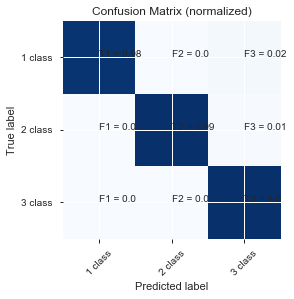

In [149]:
cm_matrix_plot(cm)

In [337]:
print("f1_score (test): ", f1_score(y_test, grid_clf_xgb.predict(X_test), average='macro'))

f1_score (test):  0.9932956170509302


In [338]:
#df_results.at[3,'f1 score (train)']=f1_score(y_train, grid_clf_xgb.predict(X_train), average='macro')
#df_results.at[3,'f1 score (test)']=f1_score(y_test, grid_clf_xgb.predict(X_test), average='macro')

In [339]:
#df_results

,Name,f1 score (train),f1 score (test)
0,Logistic regression,0.000000,0.000000
1,Log regr with new features,0.000000,0.000000
2,Log regr + feature selection,0.936333,0.913262
3,Boosting,0.996062,0.993296
4,Neural Network (1 слой),0.000000,0.000000


## Neural Networks

In [333]:
import keras
from keras.callbacks import Callback, History
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils, to_categorical

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from IPython.display import display

In [334]:
from matplotlib.ticker import MaxNLocator

class TrainingHistory(keras.callbacks.Callback):
    """
    Class to accumulate and plot metrics.
    Can be used separately or as a Keras callback.
    """
    def __init__(self, metric='acc', metric_name='Accuracy'):
        super().__init__()
        self.metric = metric
        self.metric_name = metric_name
        self.train_loss_list = []
        self.train_metric_list = []
        self.test_loss_list = []
        self.test_metric_list = []

    def on_epoch_end(self, batch, logs={}):
        self.train_loss_list.append(logs.get('loss'))
        self.test_loss_list.append(logs.get('val_loss'))
        self.train_metric_list.append(logs.get(self.metric))
        self.test_metric_list.append(logs.get('val_%s' % self.metric))
        
        epoch_num = len(self.train_loss_list)
        if epoch_num % 10 == 0:
            print('Epoch {0}: loss={1} {2}={3:.4f}'.format(epoch_num, self.train_loss_list[-1],
                                                           self.metric, self.train_metric_list[-1]))
    
    def print_scores(self):
        
        print('{0}: train={1:.4f}, test={2:.4f}'.format(self.metric_name,
                                                        self.train_metric_list[-1],
                                                        self.test_metric_list[-1]))
        print('Loss: train={0:.4f}, test={1:.4f}'.format(self.train_loss_list[-1],
                                                         self.test_loss_list[-1]))
            
    def plot(self):
        f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        plt.subplots_adjust(wspace=0.2, hspace=0.2)

        axes[0].set_title('Loss', fontsize=16, fontweight='bold')
        axes[1].set_title(self.metric_name, fontsize=16, fontweight='bold')

        axes[0].plot(self.train_loss_list, label='Train set')
        axes[0].plot(self.test_loss_list, label='Test set')

        axes[1].plot(self.train_metric_list, label='Train set')
        axes[1].plot(self.test_metric_list, label='Test set')

        axes[0].set_xlabel("Epoch")
        axes[1].set_xlabel("Epoch")

        # Only integer epoch labels
        axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
        axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

        axes[0].legend()
        axes[1].legend()

### Preprocessing

In [335]:
df = pd.read_csv('dataset_57_hypothyroid.csv', na_values='?', true_values='t', false_values='f')
df.drop(['TBG_measured', 'TBG', 'referral_source'], inplace=True, axis=1)
df.drop(['hypopituitary'], inplace=True, axis=1)
df['Class'] = df['Class'].str.slice(0,3)
df['sex'] = df['sex'].map({'M': True, 'F': False})

df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,Class
0,41.0,False,False,False,False,False,False,False,False,False,...,1.30,True,2.5,True,125.0,True,1.14,True,109.0,neg
1,23.0,False,False,False,False,False,False,False,False,False,...,4.10,True,2.0,True,102.0,False,NaN,False,NaN,neg
2,46.0,True,False,False,False,False,False,False,False,False,...,0.98,False,NaN,True,109.0,True,0.91,True,120.0,neg
3,70.0,False,True,False,False,False,False,False,False,False,...,0.16,True,1.9,True,175.0,False,NaN,False,NaN,neg
4,70.0,False,False,False,False,False,False,False,False,False,...,0.72,True,1.2,True,61.0,True,0.87,True,70.0,neg


In [336]:
df = df[df['Class'] != 'sec']
df = df[df.age < 400]

idx = df[df['sex'].isnull()][df['pregnant'] == True].index
df.loc[idx, 'sex'] = False
print('Inferred gender for %i rows.' % len(idx))

orig_length = len(df)
df = df.dropna(subset=['sex'])
new_length = len(df)
print('Rows dropped because of missing gender:', orig_length - new_length)

C:\Users\123\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Inferred gender for 2 rows.
Rows dropped because of missing gender: 148


In [337]:
df['FTI'] = np.log1p(df['FTI'])
df['T3'] = np.log1p(df['T3'])
df['TSH'] = np.log1p(df['TSH'])
df['TT4'] = np.log1p(df['TT4'])

In [338]:
MEASUREMENT_COLS = (
    ('TSH_measured', 'TSH'),
    ('T3_measured', 'T3'),
    ('TT4_measured', 'TT4'),
    ('T4U_measured', 'T4U'),
    ('FTI_measured', 'FTI'),
)

for _, col in MEASUREMENT_COLS:
    for cls, mean in dict(df.groupby('Class')[col].agg('mean')).items():
        idx = df[df[col].isnull()][df['Class'] == cls].index
        df.loc[idx, col] = mean

rows_with_nan = df.isnull().any(axis=1).sum()
print('Rows with NaN: %i (%.0f%%)' % (rows_with_nan, rows_with_nan * 100 / len(df)))

Rows with NaN: 0 (0%)


C:\Users\123\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\123\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\123\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\123\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\123\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_pa

In [339]:
target = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Class', axis=1), target, stratify=target, random_state=42
)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\123\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype bool, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\123\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype bool, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\123\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype bool, float64, object were all converted to float64 by StandardScaler.
  


In [340]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)

y_train_onehot = np_utils.to_categorical(encoder.transform(y_train))
y_test_onehot = np_utils.to_categorical(encoder.transform(y_test))

In [341]:
print('X_train shape:', X_train.shape)
print('y_train_onehot shape:', y_train_onehot.shape)
print('X_test shape:', X_test.shape)
print('y_test_onehot shape:', y_test_onehot.shape)

num_classes = y_train_onehot.shape[1]
print('Number of classes:', num_classes)

X_train shape: (2715, 25)
y_train_onehot shape: (2715, 3)
X_test shape: (905, 25)
y_test_onehot shape: (905, 3)
Number of classes: 3


In [342]:
batch_size = 20
learning_rate = 0.01
alpha = 0.001    # regularization
n_epochs = 100

### Using Keras

In [343]:
from keras import backend as K; K.clear_session() # TODO: fix this
tf.reset_default_graph()

adam = keras.optimizers.Adam()

model = Sequential()
model.add(Dense(num_classes, input_dim=X_train.shape[1], activation='softmax', activity_regularizer=l2(0.01)))
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer=adam)

history = TrainingHistory(metric='categorical_accuracy', metric_name='Accuracy')

model.fit(
    X_train, y_train_onehot, epochs=1000, batch_size=32, verbose=0,
    validation_data=(X_test, y_test_onehot),
    callbacks=[history], initial_epoch=len(history.train_loss_list)
)

score, accuracy = model.evaluate(X_train, y_train_onehot, batch_size=batch_size, verbose=0)
print("\nTrain Loss = {:.2f}".format(score))
print("Train Accuracy = {:.2f}".format(accuracy))

score, accuracy = model.evaluate(X_test, y_test_onehot, batch_size=batch_size, verbose=0)
print("\nTest Loss = {:.2f}".format(score))
print("Test Accuracy = {:.2f}".format(accuracy))

Epoch 10: loss=0.6488407003286794 categorical_accuracy=0.9473
Epoch 20: loss=0.4844386476179513 categorical_accuracy=0.9562
Epoch 30: loss=0.4369363802353102 categorical_accuracy=0.9606
Epoch 40: loss=0.4135946936480029 categorical_accuracy=0.9646
Epoch 50: loss=0.3993701353916147 categorical_accuracy=0.9676
Epoch 60: loss=0.38990311635791924 categorical_accuracy=0.9702
Epoch 70: loss=0.382959074956497 categorical_accuracy=0.9724
Epoch 80: loss=0.3779357766029365 categorical_accuracy=0.9753
Epoch 90: loss=0.37412551550355844 categorical_accuracy=0.9761
Epoch 100: loss=0.37123136792613215 categorical_accuracy=0.9786
Epoch 110: loss=0.368978108567208 categorical_accuracy=0.9783
Epoch 120: loss=0.36714316323317214 categorical_accuracy=0.9812
Epoch 130: loss=0.3657135362124575 categorical_accuracy=0.9816
Epoch 140: loss=0.3644908883185237 categorical_accuracy=0.9834
Epoch 150: loss=0.3636627395069621 categorical_accuracy=0.9842
Epoch 160: loss=0.3626748040016624 categorical_accuracy=0.9853

Accuracy: train=0.9871, test=0.9867
Loss: train=0.3545, test=0.3767


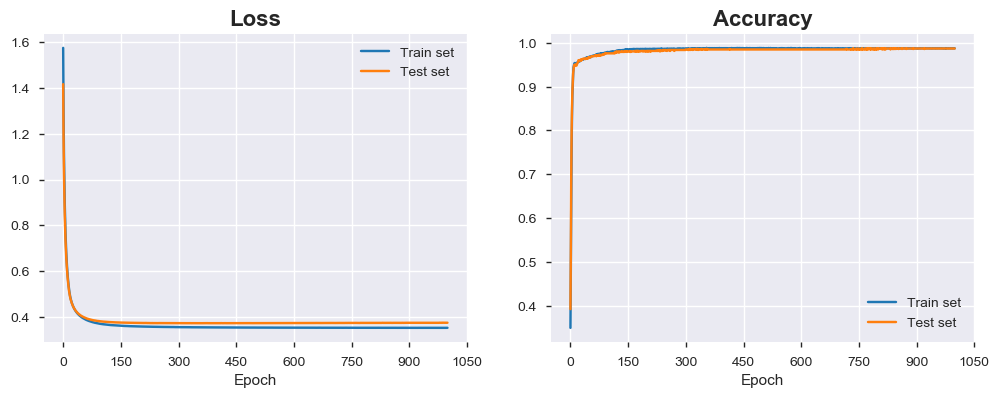

In [344]:
history.print_scores()
history.plot()
plt.show()

In [345]:
y_true_0 = y_test_onehot.argmax(axis=1)
y_predicted_scores_0 = model.predict(X_test)
y_predicted_0 = y_predicted_scores_0.argmax(axis=1)

y_true_0train = y_train_onehot.argmax(axis=1)
y_predicted_scores_0train = model.predict(X_train)
y_predicted_0train = y_predicted_scores_0train.argmax(axis=1)

In [346]:
print('Classification report\n')
print(classification_report(y_true_0, y_predicted_0))

Classification report

              precision    recall  f1-score   support

           0       0.90      0.91      0.91        47
           1       1.00      0.99      0.99       835
           2       0.87      0.87      0.87        23

   micro avg       0.99      0.99      0.99       905
   macro avg       0.92      0.93      0.92       905
weighted avg       0.99      0.99      0.99       905



In [347]:
f1_score(y_true_0train, y_predicted_0train, average='macro') #train

0.9333345207138531

In [348]:
f1_score(y_true_0, y_predicted_0, average='macro') # test

0.9231453082389459

In [349]:
df_results.at[5,'f1 score (train)']=f1_score(y_true_0train, y_predicted_0train, average='macro')
df_results.at[5,'f1 score (test)']=f1_score(y_true_0, y_predicted_0, average='macro') 

In [350]:
df_results

,Name,f1 score (train),f1 score (test)
0,Logistic regression,0.896840,0.867979
1,Log regr with new features,0.971030,0.917302
2,Log regr + feature selection,0.936333,0.913262
3,Decision tree,0.929329,0.848873
4,Boosting,0.997383,0.979087
5,Neural Network (1 слой),0.933335,0.923145


In [351]:
def f1(y_true,y_pred):
    TP = K.eval(K.sum(K.cast(y_true * y_pred, 'float'), axis=0))
    FP = K.eval(K.sum(K.cast((1-y_true) * y_pred, 'float'), axis=0))
    FN = K.eval(K.sum(K.cast(y_true * (1-y_pred), 'float'), axis=0))
    precision = K.eval(K.sum(TP, axis=0)) / K.eval(K.sum(TP + FP + K.epsilon(), axis=0))
    recall = K.eval(K.sum(TP, axis=0)) / K.eval(K.sum(TP + FN + K.epsilon(), axis=0))
    
    f1_score = 2*precision*recall / (precision+recall+K.epsilon())
    return f1_score

In [352]:
from keras import backend as K; K.clear_session()
tf.reset_default_graph()

adam = keras.optimizers.Adam()

from keras import backend as K


model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(20, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer=adam)

history = TrainingHistory(metric='categorical_accuracy', metric_name='Accuracy')

model.fit(
    X_train, y_train_onehot, epochs=700, batch_size=10, verbose=0,
    validation_data=(X_test, y_test_onehot),
    callbacks=[history], initial_epoch=len(history.train_loss_list)
)


Epoch 10: loss=0.1040696177342615 categorical_accuracy=0.9591
Epoch 20: loss=0.05969225185254958 categorical_accuracy=0.9779
Epoch 30: loss=0.05032059366935013 categorical_accuracy=0.9823
Epoch 40: loss=0.0460356525841971 categorical_accuracy=0.9831
Epoch 50: loss=0.03213446053655064 categorical_accuracy=0.9878
Epoch 60: loss=0.037558286937895896 categorical_accuracy=0.9856
Epoch 70: loss=0.03675095579887856 categorical_accuracy=0.9890
Epoch 80: loss=0.031206711154902814 categorical_accuracy=0.9890
Epoch 90: loss=0.030202452781965608 categorical_accuracy=0.9901
Epoch 100: loss=0.02833256792448843 categorical_accuracy=0.9901
Epoch 110: loss=0.02972348871661485 categorical_accuracy=0.9893
Epoch 120: loss=0.028292634508575994 categorical_accuracy=0.9890
Epoch 130: loss=0.029001872256573694 categorical_accuracy=0.9886
Epoch 140: loss=0.02258606607852868 categorical_accuracy=0.9930
Epoch 150: loss=0.02235551135657728 categorical_accuracy=0.9923
Epoch 160: loss=0.02614769294698422 categorica

Accuracy: train=0.9948, test=0.9856
Loss: train=0.0187, test=0.0955


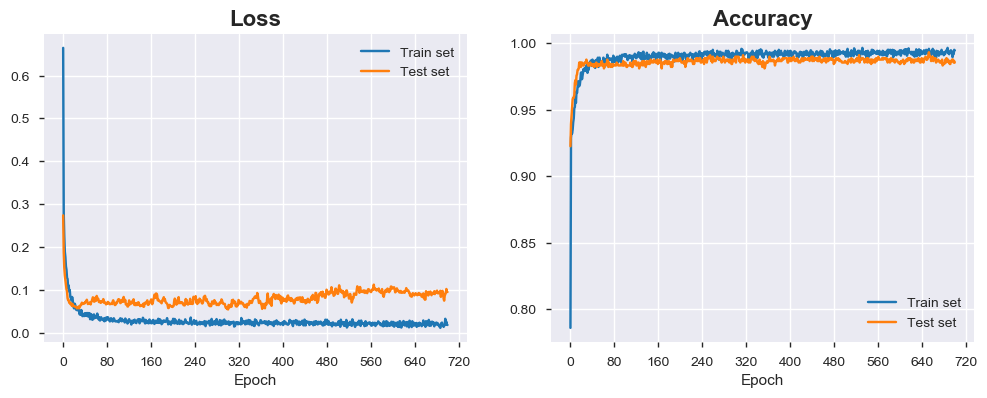

In [353]:
history.print_scores()
history.plot()
plt.show()

In [361]:
y_true_0 = y_test_onehot.argmax(axis=1)
y_predicted_scores_0 = model.predict(X_test)
y_predicted_0 = y_predicted_scores_0.argmax(axis=1)

y_true_0train = y_train_onehot.argmax(axis=1)
y_predicted_scores_0train = model.predict(X_train)
y_predicted_0train = y_predicted_scores_0train.argmax(axis=1)

In [362]:
print('Classification report\n')
print(classification_report(y_true_0, y_predicted_0))

Classification report

              precision    recall  f1-score   support

           0       0.91      0.85      0.88        47
           1       0.99      1.00      0.99       835
           2       0.90      0.83      0.86        23

   micro avg       0.99      0.99      0.99       905
   macro avg       0.94      0.89      0.91       905
weighted avg       0.99      0.99      0.99       905



In [363]:
f1_score(y_true_0train, y_predicted_0train, average='macro') #train

0.9477841876875054

In [364]:
f1_score(y_true_0, y_predicted_0, average='macro') # test

0.9124613694762949

In [365]:
df_results.at[6,'f1 score (train)']=f1_score(y_true_0train, y_predicted_0train, average='macro')
df_results.at[6,'f1 score (test)']=f1_score(y_true_0, y_predicted_0, average='macro') 
df_results.at[6,'Name']='Neural Network (2 слоя)'

In [359]:
df_results

,Name,f1 score (train),f1 score (test)
0,Logistic regression,0.896840,0.867979
1,Log regr with new features,0.971030,0.917302
2,Log regr + feature selection,0.936333,0.913262
3,Decision tree,0.929329,0.848873
4,Boosting,0.997383,0.979087
5,Neural Network (1 слой),0.933335,0.923145
6,Neural Network (2 слоя),0.947784,0.912461


## Выводы

Полученные результаты:

In [360]:
df_results

,Name,f1 score (train),f1 score (test)
0,Logistic regression,0.896840,0.867979
1,Log regr with new features,0.971030,0.917302
2,Log regr + feature selection,0.936333,0.913262
3,Decision tree,0.929329,0.848873
4,Boosting,0.997383,0.979087
5,Neural Network (1 слой),0.933335,0.923145
6,Neural Network (2 слоя),0.947784,0.912461
